## Import the necessary libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
import math

# To fetch financial data
from trading_volatility import TradingVolatility

# For visualisation
import seaborn as sns
sns.set_style("darkgrid")

# For performance measure
from perf_measure import performance_metrics

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

## Strategy 1: Long Short VIX (LSV)

### 1. Data loading and preprocessing

In [2]:
# Tickers to be used in research
vol_tickers = ['VIXY', 'SVXY']
vol_indices = ['^VIX']

In [3]:
vol_trader = TradingVolatility(volatility_assets=vol_tickers,
                               volatility_indices=vol_indices)

# Historical data for 1-month VIX futures cannot be retreived using Yahoo Finanace API, hence manual upload
vol_trader.get_data(start_date="2011-10-11",
                    end_date="2020-04-01",
                    col_rename='vx_open',
                    manual_loading="S&P 500 VIX Futures Historical Data.csv")

2024-11-09 16:26:15,311 - INFO - File loaded successfully.
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,vixy_open,vixy_close,svxy_open,svxy_close,^vix_open,vx_open
Date,,,,,,
2011-10-11,809440.000000,790160.000000,12.0625,12.3150,33.950001,34.67
2011-10-12,761280.000000,736800.000000,12.7900,13.1725,31.570000,34.47
2011-10-13,745600.000000,735360.000000,13.0000,13.0675,31.990000,32.80
2011-10-14,703440.000000,692560.000000,13.8475,13.9375,29.070000,31.13
2011-10-17,696000.000000,765760.000000,13.7250,12.4050,30.350000,29.42
...,...,...,...,...,...,...
2020-03-25,3160.000000,3328.000000,15.4800,15.0650,61.439999,47.00
2020-03-26,3222.399902,3036.000000,15.2250,15.6750,65.669998,51.50
2020-03-27,3301.600098,3304.800049,14.8600,14.9250,64.949997,46.35


> Note: 1-to-4 reverse stock split for VIXY announced on 1/11/2024, hence price changes from previous version of notebook. 

In [4]:
# Check if the data was loaded
vol_trader.data.tail()

,vixy_open,vixy_close,svxy_open,svxy_close,^vix_open,vx_open
Date,,,,,,
2020-03-25,3160.000000,3328.000000,15.480,15.065,61.439999,47.00
2020-03-26,3222.399902,3036.000000,15.225,15.675,65.669998,51.50
2020-03-27,3301.600098,3304.800049,14.860,14.925,64.949997,46.35
2020-03-30,3312.800049,3199.199951,14.900,15.125,66.300003,55.45
2020-03-31,3211.199951,3034.399902,15.085,15.505,56.689999,49.60


### 2. Signals Generation

If basis is negative then term structure is backwardation. If basis is positive, then term structure is contango.

Formula for basis:
$$B_{t}=\frac{VIX_{1}}{VIX_{spot}}-1$$

>Note: This calculation is included in the `._lsv_signals` method, but if you want to you can use `._TradingVolatility__daily_basis` method to view the basis for each trading day after you've run the `._lsv_signals` method.

Next, we want to generate the buy/sell signals for our LSV strategy. For each trading day:

1. We first check the basis
2. If negative, then vix futures term sturcture in backwardation (i.e. shorter term maturites are priced higher than longer-dated maturities - demand for S&P options might have surged due to higer risk and uncertainty in the markt which in turn affects VIX index and VIX futures given their inverse relationship with the S&P)
3. If in backwardation, we want exposure to asset that longs the VIX futures (i.e. `VIXY`) as well as removing short exposure to VIX futures (i.e. `SVXY`)
4. Consequently, there can be 3 scenarios that can occur at market open on each trading day:

    i. If there is no open long position in either VIXY or SVXY, then we generate a `buy_signal` for VIXY at its market open price

    ii. If there is an open position in SVXY but no open position in VIXY, then we create a `sell_signal` as well as a `buy_signal` for VIXY, both at the market open price
    
    iii. Lastly, if there is already an open position in VIXY, then we don't have to generate any signal for the day

In [5]:
# Method signature as such to help us identify the individual index tickers for basis calculation
vol_trader._TradingVolatility__lsv_signals(long_vix_asset="VIXY",
                                           short_vix_asset="SVXY",
                                           future_index_ticker="VX",
                                           spot_index_ticker="^VIX")

,vixy_sell_signal,svxy_sell_signal,vixy_buy_signal,svxy_buy_signal
Date,,,,
2011-10-11,NaN,NaN,NaN,12.0625
2011-10-12,NaN,NaN,NaN,NaN
2011-10-13,NaN,NaN,NaN,NaN
2011-10-14,NaN,NaN,NaN,NaN
2011-10-17,NaN,13.725,696000.0,NaN
...,...,...,...,...
2020-03-25,NaN,NaN,NaN,NaN
2020-03-26,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN


In [6]:
# Check to see if the basis column was added  to `data` after generating our signals
vol_trader.data

,vixy_open,vixy_close,svxy_open,svxy_close,^vix_open,vx_open,basis
Date,,,,,,,
2011-10-11,809440.000000,790160.000000,12.0625,12.3150,33.950001,34.67,0.021208
2011-10-12,761280.000000,736800.000000,12.7900,13.1725,31.570000,34.47,0.091859
2011-10-13,745600.000000,735360.000000,13.0000,13.0675,31.990000,32.80,0.025320
2011-10-14,703440.000000,692560.000000,13.8475,13.9375,29.070000,31.13,0.070863
2011-10-17,696000.000000,765760.000000,13.7250,12.4050,30.350000,29.42,-0.030643
...,...,...,...,...,...,...,...
2020-03-25,3160.000000,3328.000000,15.4800,15.0650,61.439999,47.00,-0.235026
2020-03-26,3222.399902,3036.000000,15.2250,15.6750,65.669998,51.50,-0.215776
2020-03-27,3301.600098,3304.800049,14.8600,14.9250,64.949997,46.35,-0.286374


In [7]:
vol_trader.lsv_strategy(intial_capital=100000,
                        long_vix_asset="VIXY",
                        short_vix_asset="SVXY",
                        future_index_ticker="VX",
                        spot_index_ticker="^VIX")

,asset_history,holding_quantity,available_cash,asset_close_price,asset_value,portfolio_value,portfolio_returns,portfolio_cumulative_returns
Date,,,,,,,,
2011-10-11,svxy,8290.15,0.065625,12.315000,1.020932e+05,1.020933e+05,NaN,NaN
2011-10-12,svxy,8290.15,0.065625,13.172500,1.092020e+05,1.092021e+05,0.069630,0.069630
2011-10-13,svxy,8290.15,0.065625,13.067500,1.083315e+05,1.083316e+05,-0.007971,0.061104
2011-10-14,svxy,8290.15,0.065625,13.937500,1.155440e+05,1.155440e+05,0.066577,0.131750
2011-10-17,vixy,0.16,2422.377537,765760.000000,1.225216e+05,1.249440e+05,0.081354,0.223822
...,...,...,...,...,...,...,...,...
2020-03-25,vixy,9183.64,27.751843,3328.000000,3.056315e+07,3.056318e+07,0.081081,298.365324
2020-03-26,vixy,9183.64,27.751843,3036.000000,2.788153e+07,2.788156e+07,-0.087740,272.098919
2020-03-27,vixy,9183.64,27.751843,3304.800049,3.035009e+07,3.035012e+07,0.088537,296.278409


In [9]:
lsv_perf = performance_metrics(lsv, "portfolio_value", "Date")
lsv_perf.GeR_metric()

np.float64(0.5866454178900419)

<Axes: xlabel='Date'>

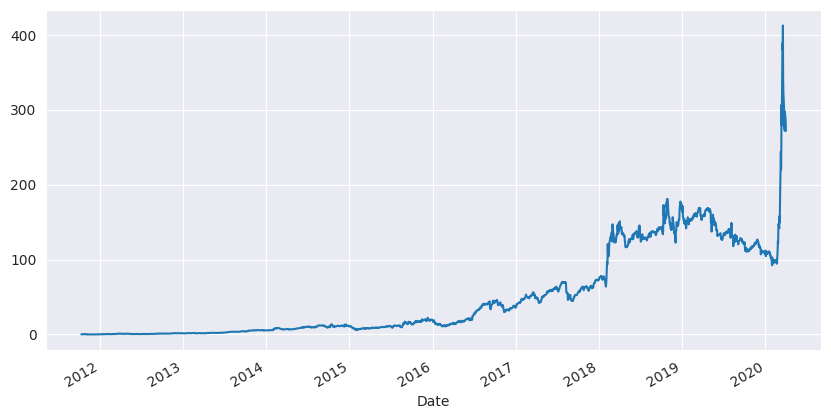

In [10]:
lsv["portfolio_cumulative_returns"].plot(figsize=(10,5))

## Strategy 2: Hedged Long Short VIX (HLSV) 

In [ ]:
def hlsv_strategy(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()

    vixy_open_long_price = []
    vixy_close_long_price = []

    svxy_open_long_price = []
    svxy_close_long_price = []

    spy_open_long_price = []
    spy_close_long_price = []
    spy_open_short_price = []
    spy_close_short_price = []

    vixy_long_position = False
    svxy_long_position = False
    spy_long_position = False
    spy_short_position = False

    for i in range(len(tmp)):
        # If basis is negative
        if tmp['basis'][i] < 0:
            if vixy_long_position == False and spy_long_position == False:
                if svxy_long_position == False and spy_short_position == False:
                    vixy_open_long_price.append(tmp['vixy_open'][i])
                    spy_open_long_price.append(tmp['spy_open'][i])

                    vixy_close_long_price.append(np.nan)
                    svxy_open_long_price.append(np.nan)
                    svxy_close_long_price.append(np.nan)
                    spy_close_long_price.append(np.nan)
                    spy_open_short_price.append(np.nan)
                    spy_close_short_price.append(np.nan)

                    vixy_long_position = True
                    spy_long_position = True

                else:
                    svxy_close_long_price.append(tmp['svxy_open'][i])
                    spy_close_short_price.append(tmp['spy_open'][i])  # this is to close spy short position

                    svxy_long_position = False
                    spy_short_position = False

                    vixy_open_long_price.append(tmp['vixy_open'][i])
                    spy_open_long_price.append(tmp['spy_open'][i])
                
                    vixy_long_position = True
                    spy_long_position = True

                    svxy_open_long_price.append(np.nan)
                    vixy_close_long_price.append(np.nan)
                    spy_open_short_price.append(np.nan)
                    spy_close_long_price.append(np.nan)
                
            else:
                vixy_open_long_price.append(np.nan)
                vixy_close_long_price.append(np.nan)
                svxy_open_long_price.append(np.nan)
                svxy_close_long_price.append(np.nan)
                spy_open_long_price.append(np.nan)
                spy_close_long_price.append(np.nan)
                spy_open_short_price.append(np.nan)
                spy_close_short_price.append(np.nan)
        # if the basis is positive      
        else:
            if svxy_long_position == False and spy_short_position == False:
                if vixy_long_position == False and spy_long_position == False:
                    svxy_open_long_price.append(tmp['svxy_open'][i])
                    spy_open_short_price.append(tmp['spy_open'][i])   # this is to open a short position in SPY

                    svxy_long_position = True
                    spy_short_position = True

                    vixy_open_long_price.append(np.nan)
                    vixy_close_long_price.append(np.nan)
                    svxy_close_long_price.append(np.nan)
                    spy_open_long_price.append(np.nan)
                    spy_close_long_price.append(np.nan)
                    spy_close_short_price.append(np.nan)
                
                else:
                    vixy_close_long_price.append(tmp['vixy_open'][i])
                    spy_close_long_price.append(tmp['spy_open'][i])  # this is to close long position in SPY

                    vixy_long_position = False
                    spy_long_position = False

                    svxy_open_long_price.append(tmp['svxy_open'][i])
                    spy_open_short_price.append(tmp['spy_open'][i])   # this is to open a short position in SPY

                    svxy_long_position = True
                    spy_short_position = True

                    vixy_open_long_price.append(np.nan)
                    svxy_close_long_price.append(np.nan)
                    spy_open_long_price.append(np.nan)
                    spy_close_short_price.append(np.nan)

            else:
                vixy_open_long_price.append(np.nan)
                vixy_close_long_price.append(np.nan)
                svxy_open_long_price.append(np.nan)
                svxy_close_long_price.append(np.nan)
                spy_open_long_price.append(np.nan)
                spy_close_long_price.append(np.nan)
                spy_open_short_price.append(np.nan)
                spy_close_short_price.append(np.nan)

    res = pd.DataFrame(index=tmp.index)
    
    res[["vixy_open_long_price","vixy_close_long_price","svxy_open_long_price","svxy_close_long_price",
        "spy_open_long_price","spy_close_long_price","spy_open_short_price","spy_close_short_price"]
        ] = pd.Series([vixy_open_long_price, vixy_close_long_price, svxy_open_long_price,\
            svxy_close_long_price,spy_open_long_price,spy_close_long_price,spy_open_short_price,spy_close_short_price])
    
    return res

hlsv = hlsv_strategy(data)

In [17]:
hlsv

,vixy_open_long_price,vixy_close_long_price,svxy_open_long_price,svxy_close_long_price,spy_open_long_price,spy_close_long_price,spy_open_short_price,spy_close_short_price
Date,,,,,,,,
2011-10-11,NaN,NaN,24.125,NaN,NaN,NaN,118.870003,NaN
2011-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-17,174000.0,NaN,NaN,27.450001,121.989998,NaN,NaN,121.989998
...,...,...,...,...,...,...,...,...
2020-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
